<a href="https://colab.research.google.com/github/Zulfahanamaulida/TA_Deteksi-Residu-Pestisida/blob/main/Percobaan_1_Arsitektur_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data input : Data image multiclass dari citra 0 sampai 10000 mg/l | Tanpa ROI

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

In [2]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define the path to the directory containing the dataset
dataset_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Image/Multiclass/'

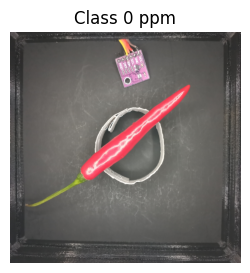

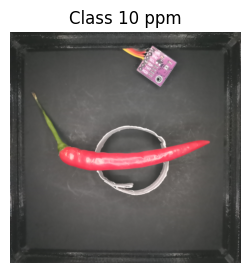

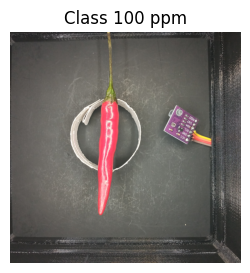

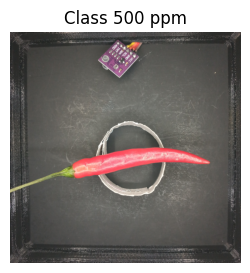

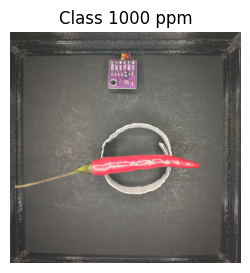

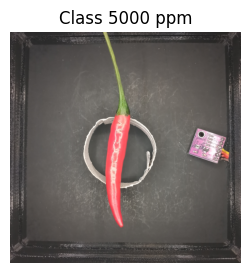

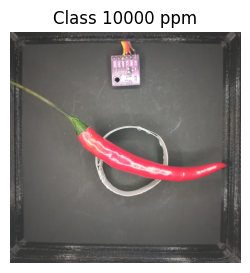

Class: 0 ppm - Number of data points: 150
Class: 10 ppm - Number of data points: 150
Class: 100 ppm - Number of data points: 150
Class: 500 ppm - Number of data points: 150
Class: 1000 ppm - Number of data points: 150
Class: 5000 ppm - Number of data points: 150
Class: 10000 ppm - Number of data points: 150


In [4]:
# Load images and labels
X = []
y = []
class_counts = {}  # Dictionary to store counts for each class
images_per_class = 1  # Number of images to display per class

for class_idx, class_folder in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        class_name = class_folder
        class_count = 0  # Initialize count for the current class
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)  # Read image
            if class_count < images_per_class:  # Display only a few images from each class
                plt.figure(figsize=(3, 3))
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.title(f"Class {class_name}")
                plt.axis('off')
                plt.show()
            img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)  # Resize image to 28x28
            X.append(img)
            y.append(class_idx)
            class_count += 1  # Increment count for the current class
        class_counts[class_name] = class_count  # Store count for the current class

X = np.array(X)
y = np.array(y)

# Print class names and number of data points in each class
for class_name, count in class_counts.items():
    print("Class:", class_name, "- Number of data points:", count)

In [5]:
# Normalize pixel values to range [0, 1]
X = X.astype('float32') / 255.0

# Convert labels to categorical one-hot encoding
y = to_categorical(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Define the model architecture
def VGG_16(_input = Input((28,28,3))):  # Adjust input shape for color images
    # Block 1
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(_input)
    conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv2)
    # Block 2
    conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D((2, 2))(conv4)
    # Fully Connected layers
    flat = Flatten()(pool2)
    dense1 = Dense(256, activation='relu')(flat)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(7, activation='softmax')(dense2)  # Adjust output units to 7 for multi-class classification
    VGG16_model = Model(inputs=_input, outputs=output)
    return VGG16_model

# Instantiate the model
model = VGG_16()

# Define learning rate
learning_rate = 0.001

# Define your optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                           

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=3)])
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

Epoch 1/20
27/27 [==============================] - 5s 125ms/step - loss: 1.9515 - accuracy: 0.1500 - val_loss: 1.9452 - val_accuracy: 0.1333
Epoch 2/20
27/27 [==============================] - 3s 117ms/step - loss: 1.9459 - accuracy: 0.1583 - val_loss: 1.9452 - val_accuracy: 0.1810
Epoch 3/20
27/27 [==============================] - 3s 117ms/step - loss: 1.9228 - accuracy: 0.2060 - val_loss: 1.9397 - val_accuracy: 0.1476
Epoch 4/20
27/27 [==============================] - 5s 174ms/step - loss: 1.9020 - accuracy: 0.1964 - val_loss: 1.9939 - val_accuracy: 0.1286
Epoch 5/20
27/27 [==============================] - 3s 116ms/step - loss: 1.9532 - accuracy: 0.1298 - val_loss: 1.9402 - val_accuracy: 0.1333
Epoch 6/20
27/27 [==============================] - 3s 116ms/step - loss: 1.9409 - accuracy: 0.1536 - val_loss: 1.9329 - val_accuracy: 0.1333
Epoch 7/20
27/27 [==============================] - 3s 114ms/step - loss: 1.8792 - accuracy: 0.1976 - val_loss: 1.8196 - val_accuracy: 0.2714
Epoch 

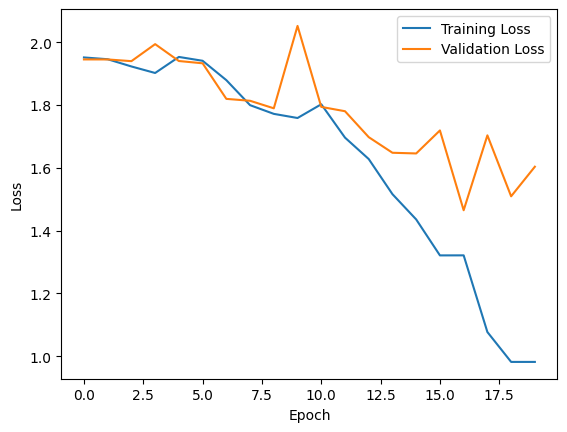

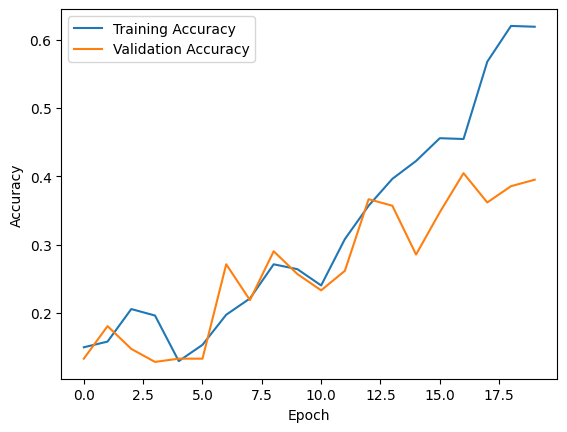

In [11]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

7/7 [==============================] - 0s 28ms/step


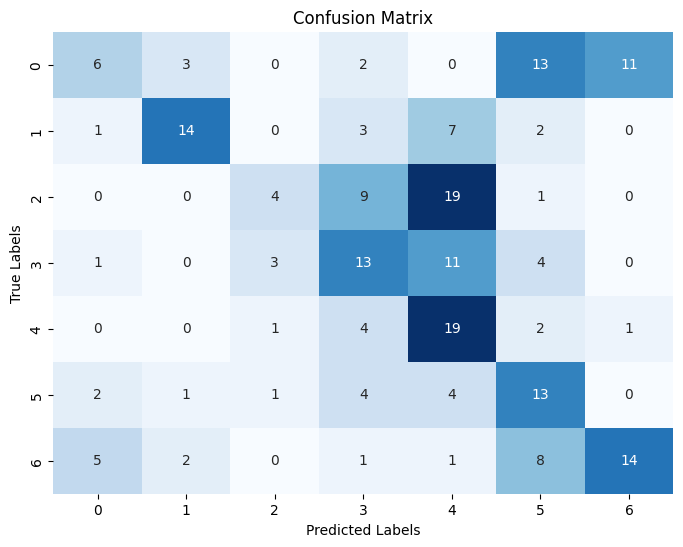

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.17      0.24        35
           1       0.70      0.52      0.60        27
           2       0.44      0.12      0.19        33
           3       0.36      0.41      0.38        32
           4       0.31      0.70      0.43        27
           5       0.30      0.52      0.38        25
           6       0.54      0.45      0.49        31

    accuracy                           0.40       210
   macro avg       0.44      0.41      0.39       210
weighted avg       0.44      0.40      0.38       210



In [12]:
# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes)

# Print classification report
print("Classification Report:\n", class_report)


In [13]:
# Define the path to save the model
save_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Arsitektur VGG16/Percobaan 1/model.h5'

# Save the trained model
model.save(save_path)
print("Model saved at:", save_path)


Model saved at: /content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Arsitektur VGG16/Percobaan 1/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
